# Flow of ReAct Multi Agent - Research and Action

![Multi Agent](ReAct-agents.png "Multi Agent")


In [2]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL # to run python code in string
from langchain_community.tools import DuckDuckGoSearchRun ## Research tool

In [3]:
load_dotenv()

True

In [4]:
groq_model = ChatGroq(model_name="llama3-8b-8192")
groq_model.invoke("give python graph code")

AIMessage(content='Here is an example of how to create a graph using Python:\n\n**Using NetworkX library**\n\nNetworkX is a Python library used for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.\n\nHere is an example code:\n```\nimport networkx as nx\nimport matplotlib.pyplot as plt\n\n# Create an empty graph\nG = nx.Graph()\n\n# Add nodes\nG.add_node("A")\nG.add_node("B")\nG.add_node("C")\nG.add_node("D")\n\n# Add edges\nG.add_edge("A", "B")\nG.add_edge("B", "C")\nG.add_edge("C", "D")\nG.add_edge("D", "A")\n\n# Draw the graph\npos = nx.spring_layout(G)\nnx.draw_networkx(G, pos, with_labels=True)\nplt.show()\n```\nThis code creates a graph with 4 nodes and 4 edges, and then draws it using the `spring_layout` function to position the nodes and the `draw_networkx` function to draw the edges.\n\n**Using Matplotlib library**\n\nMatplotlib is a Python library used for creating static, animated, and interactive visualizations in python.\n

In [5]:
search_tool = DuckDuckGoSearchRun()

In [6]:
search_tool.invoke("What is the capital of India?")

"New Delhi, national capital of India. It is situated in the north-central part of the country on the west bank of the Yamuna River, adjacent to and just south of Delhi city (Old Delhi) and within the Delhi national capital territory. Learn more about New Delhi in this article. Delhi is a city and national capital territory in north-central India. The city of Delhi actually consists of two components: Old Delhi, in the north, the historic city; and New Delhi, in the south, since 1947 the capital of India, built in the first part of the 20th century as the capital of British India. India is a country that occupies the greater part of South Asia. It is a constitutional republic that represents a highly diverse population consisting of thousands of ethnic groups. It is made up of eight union territories and 28 states, and its capital is New Delhi. Learn why New Delhi is the capital of India since 1911, and what was the original name and location of the capital before that. Find out more f

In [7]:
repl = PythonREPL()

Python REPL can execute arbitrary code. Use with caution.


''

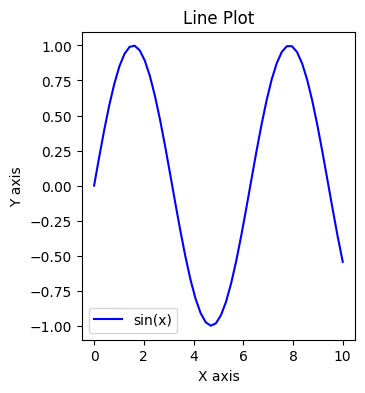

In [8]:
repl.run("""
     import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = np.linspace(0, 10, 50)
y1 = np.sin(x)
y2 = np.cos(x)

# Create a figure with multiple subplots
plt.figure(figsize=(12, 4))

# Line Plot
plt.subplot(1, 3, 1)
plt.plot(x, y1, label='sin(x)', color='blue')
plt.title('Line Plot')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend()
     """)

In [9]:
""" 
As REPL is not a tool, but agent only works with the tools, we need to convert it into a tool using annotation

@Params
code: Annotated[str, "..."] provides type information and description for the parameter.
This annotation helps the AI understand that it should pass Python code as a string to this function
"""

@tool # Convert function into a tool so that it will be callable by the agent
def python_repl_tool(code: Annotated[str, "The python code to create and display data"]):
    """
    Use this tool to execute Python code to display data using pandas.
    DO NOT use matplotlib or plotting libraries.
    Simply create and print pandas DataFrames.
    """
    try:
        result = repl.run(code)
        return (f"Successfully executed the code. Results:\n\n{result}", 
                "\n\nIf you have completed the task, respond with FINAL ANSWER")
    except Exception as e:
        return (f"Error: {str(e)}. Please try again with simpler code that only uses pandas.", 
                "\n\nIf you have completed the task, respond with FINAL ANSWER")

In [10]:
def make_research_prompt(instruction:str)->str:
    return (
        "You are a research assistant specializing in data collection. Your ONLY available tool is"
        " the DuckDuckGo search tool. You cannot execute code or generate charts."
        "\n\nWhen responding to research requests:"
        "\n1. ALWAYS use the DuckDuckGo search tool to find information"
        "\n2. Structure search results clearly with data points and values"
        "\n3. For numeric data like GDP, include specific numbers by year"
        "\n4. NEVER attempt to generate Python code or charts"
        "\n5. After finding the data, pass it to your chart generator colleague"
        "\n6. NEVER try to call functions that aren't explicitly provided to you"
        f"\n\n{instruction}"
    )

In [11]:
def make_chart_prompt(instruction:str)->str:
    return (
        "You are a data visualization expert specializing in creating charts. Your ONLY available"
        " tool is the Python REPL tool. You receive data from a research colleague and create visualizations."
        "\n\nWhen creating charts:"
        "\n1. ALWAYS use the python_repl_tool with valid, working Python code"
        "\n6. If creating a chart fails, simplify your approach and retry"
        "\n7. When finished, respond with 'FINAL ANSWER' and nothing else"
        "\n8. NEVER try to call functions that aren't explicitly provided to you"
        f"\n\n{instruction}"
    )

In [12]:
def make_system_prompt(instruction:str)->str:
    return  (
         "You are a helpful AI assistant, collaborating with other assistants."
        " You have access to a Python REPL tool. Use this tool to execute Python code for"
        " all data retrieval and visualization tasks. DO NOT try to call specialized functions"
        " like 'uk_gdp' - instead, write Python code that uses libraries like pandas, matplotlib, etc."
        " to fetch and process the data directly."
        "fetch data using duckduckgo search instead of calling specialized functions" 
        "DONT USE ANY SPECIALIZED FUNCTIONS"
        # Rest of your prompt...
        f"\n{instruction}"
    )

In [13]:
def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        return "__end__"
    
    return goto

### Defining Agents

In [14]:
research_agent = create_react_agent(
    groq_model,
    tools=[search_tool],
    prompt=make_research_prompt("You can only do research. You are working with a chart generator colleague."),
)

In [15]:
chart_agent = create_react_agent(
    groq_model,
    tools=[python_repl_tool],
    prompt=make_chart_prompt("You can only do generate chart using python code. You are working with a researcher colleague. whatever data researcher send convert it to graph"),
)

### Node Defination

In [16]:
def research_node(state: MessagesState) -> Command[Literal["chart_generator", "__end__"]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    
    return Command(
        update={"messages": result["messages"]}, # passes the updated conversation history to the next function
        goto=goto # directs the flow to transition to the goto (which we got from get_next_node)
    )

In [17]:
def chart_node(state: MessagesState) -> Command[Literal["researcher", "__end__"]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    
    return Command(update={"messages": result["messages"]}, goto=goto)

### Creating Workflow

In [18]:
workflow = StateGraph(MessagesState)

"""
Nodes -> Agents -> Tools
"""

# Define the nodes
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

# Define the input edges
workflow.add_edge(START, "researcher")

app = workflow.compile()

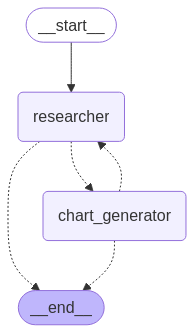

In [19]:
display(Image(app.get_graph().draw_mermaid_png()))

In [20]:
app.invoke({
    "messages": [
        ("user", 
        """Find the UK's GDP data for years 2020, 2021, and 2022.
        
        Research agent: Please search for specific GDP values in billions of pounds.
        Chart agent: to create a simple chart using the data provided by the researcher and code.
        
        Once complete, create a chart and respond with FINAL ANSWER."""
        )
    ],
})

{'messages': [HumanMessage(content="Find the UK's GDP data for years 2020, 2021, and 2022.\n\n        Research agent: Please search for specific GDP values in billions of pounds.\n        Chart agent: to create a simple chart using the data provided by the researcher and code.\n\n        Once complete, create a chart and respond with FINAL ANSWER.", additional_kwargs={}, response_metadata={}, id='586c73f3-818a-4ffb-adfd-130a72a83b86'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9j4f', 'function': {'arguments': '{"query":"UK GDP 2020 2021 2022 in billions of pounds"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 1139, 'total_tokens': 1221, 'completion_time': 0.068333333, 'prompt_time': 0.141638609, 'queue_time': 0.238718163, 'total_time': 0.209971942}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_dadc9d6142', 'finish_reason': 'tool_calls', 'logprobs': None}, id=